# ONLY OvR !

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Results

In [4]:
import os
import re
import itertools
from tqdm import tqdm
import warnings

import numpy as np
import pandas as pd
from scipy import stats

import torch
from torch.nn import functional as F

import sklearn.metrics as metrics
import sklearn.preprocessing as prep

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.colors import rgb_to_hsv,hsv_to_rgb, to_rgb
from matplotlib.legend_handler import HandlerTuple

from library import architectures, tools, evals, dataset, losses

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def get_training_log(log_path, log_item = 'Loss/train'):
    # log_path = f"./_models/{scale}/_s42/{arch}/{approach}/Logs"
    onlyfiles = [f for f in os.listdir(log_path) if os.path.isfile(os.path.join(log_path, f))]
    log_file = onlyfiles[-1]

    event_acc = EventAccumulator(os.path.join(log_path, log_file))
    event_acc.Reload()

    logs = [e.value for e in event_acc.Scalars(log_item)]

    return logs

## Large-scale experiments

### Initialize

#### Variables

In [5]:
SCALE = 'LargeScale'
ARCHITECTURE = 'ResNet_50'  
training_info = tools.load_yaml('./config/train.yaml')

approaches_abbr = {'SoftMax':'SM','EOS':'EOS','OvR':'OvR','OpenSetOvR':'DSOvR'}
approaches_full = {'SoftMax':'SoftMax Loss','EOS':'Enropic Open-Set Loss','OvR':'One-vs-Rest Loss','OpenSetOvR':'Open-Set OvR Loss'}
seeds = [42]
num_classes = [116, 30, 151]

CMAP_t10 = mpl.color_sequences['tab10']
CMAP_t20 = mpl.color_sequences['tab20']
CMAP_s1 = mpl.color_sequences['Set1']
CMAP_s2 = mpl.color_sequences['Set2']

#### Evaluation data from SM

In [6]:
sm_data_info_1 = [
        {'info':[f"{SCALE}_1", '_RQ1', f'{ARCHITECTURE}_neg_0', 'SoftMax'], 'label': 'SM'},
        {'info':[f"{SCALE}_2", '_RQ1', f'{ARCHITECTURE}_neg_0', 'SoftMax'], 'label': 'SM'},
        {'info':[f"{SCALE}_3", '_RQ1', f'{ARCHITECTURE}_neg_0', 'SoftMax'], 'label': 'SM'},
]

#### Evaluation data from EOS

In [7]:
eos_data_info_3 = [
        {'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_neg_All', 'EOS'], 'label': 'EOS (w/ neg)'},
        {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_neg_All', 'EOS'], 'label': 'EOS (w/ neg)'},
        {'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_neg_All', 'EOS'], 'label': 'EOS (w/ neg)'},
]

#### Evaluation data from OvR

In [8]:
ovr_data_info_1 = [
        {'info':[f"{SCALE}_1", '_RQ1', f'{ARCHITECTURE}_neg_0', 'OvR'], 'label': 'OvR'},
        {'info':[f"{SCALE}_2", '_RQ1', f'{ARCHITECTURE}_neg_0', 'OvR'], 'label': 'OvR'},
        {'info':[f"{SCALE}_3", '_RQ1', f'{ARCHITECTURE}_neg_0', 'OvR'], 'label': 'OvR'},
]

In [9]:
ovr_data_info_2_T = [
    {
        'C':[{'info':[f"{SCALE}_1", '_RQ2', f'{ARCHITECTURE}_C_neg_0_b', 'OvR'], 'label': 'OvR-C (b)'},
             {'info':[f"{SCALE}_1", '_RQ2', f'{ARCHITECTURE}_C_neg_0_g', 'OvR'], 'label': 'OvR-C (g)'},],
        'F':[{'info':[f"{SCALE}_1", '_RQ2', f'{ARCHITECTURE}_F_neg_0_1', 'OvR'], 'label': 'OvR-F (1)'},
             {'info':[f"{SCALE}_1", '_RQ2', f'{ARCHITECTURE}_F_neg_0_2', 'OvR'], 'label': 'OvR-F (2)'},
             {'info':[f"{SCALE}_1", '_RQ2', f'{ARCHITECTURE}_F_neg_0_3', 'OvR'], 'label': 'OvR-F (3)'},],
        'M':[{'info':[f"{SCALE}_1", '_RQ2', f'{ARCHITECTURE}_M_neg_0_02', 'OvR'], 'label': 'OvR-H (0.2)'},
             {'info':[f"{SCALE}_1", '_RQ2', f'{ARCHITECTURE}_M_neg_0_06', 'OvR'], 'label': 'OvR-H (0.6)'},]
    },
    {
        'C':[{'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_C_neg_0_b', 'OvR'], 'label': 'OvR-C (b)'},
             {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_C_neg_0_g', 'OvR'], 'label': 'OvR-C (g)'},],
        'F':[{'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_F_neg_0_1', 'OvR'], 'label': 'OvR-F (1)'},
             {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_F_neg_0_2', 'OvR'], 'label': 'OvR-F (2)'},
             {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_F_neg_0_3', 'OvR'], 'label': 'OvR-F (3)'},],
        'M':[{'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_M_neg_0_02', 'OvR'], 'label': 'OvR-H (0.2)'},
             {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_M_neg_0_06', 'OvR'], 'label': 'OvR-H (0.6)'},]
    },
    {
        'C':[{'info':[f"{SCALE}_3", '_RQ2', f'{ARCHITECTURE}_C_neg_0_b', 'OvR'], 'label': 'OvR-C (b)'},
             {'info':[f"{SCALE}_3", '_RQ2', f'{ARCHITECTURE}_C_neg_0_g', 'OvR'], 'label': 'OvR-C (g)'},],
        'F':[{'info':[f"{SCALE}_3", '_RQ2', f'{ARCHITECTURE}_F_neg_0_1', 'OvR'], 'label': 'OvR-F (1)'},
             {'info':[f"{SCALE}_3", '_RQ2', f'{ARCHITECTURE}_F_neg_0_2', 'OvR'], 'label': 'OvR-F (2)'},
             {'info':[f"{SCALE}_3", '_RQ2', f'{ARCHITECTURE}_F_neg_0_3', 'OvR'], 'label': 'OvR-F (3)'},],
        'M':[{'info':[f"{SCALE}_3", '_RQ2', f'{ARCHITECTURE}_M_neg_0_02', 'OvR'], 'label': 'OvR-H (0.2)'},
             {'info':[f"{SCALE}_3", '_RQ2', f'{ARCHITECTURE}_M_neg_0_06', 'OvR'], 'label': 'OvR-H (0.6)'},]
    },
]

In [10]:
ovr_data_info_3_T =[
    {
        'base': [{'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_neg_All', 'OvR'], 'label': 'OvR-C (b w/ neg)'}],
        'C' : [{'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_C_neg_All_b', 'OvR'], 'label': 'OvR-C (b w/ neg)'},
               {'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_C_neg_All_g', 'OvR'], 'label': 'OvR-C (g w/ neg)'},],
        'F' : [{'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_F_neg_All_1', 'OvR'], 'label': 'OvR-F (1 w/ neg)'},
               {'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_F_neg_All_2', 'OvR'], 'label': 'OvR-F (2 w/ neg)'},
               {'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_F_neg_All_3', 'OvR'], 'label': 'OvR-F (3 w/ neg)'},],
        'M' : [{'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_M_neg_All_02', 'OvR'], 'label': 'OvR-H (0.4 w/ neg)'},
               {'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_M_neg_All_06', 'OvR'], 'label': 'OvR-H (0.6 w/ neg)'},]
    },
    {
        'base': [{'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_neg_All', 'OvR'], 'label': 'OvR-C (b w/ neg)'}],
        'C' : [{'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_C_neg_All_b', 'OvR'], 'label': 'OvR-C (b w/ neg)'},
               {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_C_neg_All_g', 'OvR'], 'label': 'OvR-C (g w/ neg)'},],
        'F' : [{'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_F_neg_All_1', 'OvR'], 'label': 'OvR-F (1 w/ neg)'},
               {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_F_neg_All_2', 'OvR'], 'label': 'OvR-F (2 w/ neg)'},
               {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_F_neg_All_3', 'OvR'], 'label': 'OvR-F (3 w/ neg)'},],
        'M' : [{'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_M_neg_All_02', 'OvR'], 'label': 'OvR-H (0.4 w/ neg)'},
               {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_M_neg_All_06', 'OvR'], 'label': 'OvR-H (0.6 w/ neg)'},]
    },
    {
        'base': [{'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_neg_All', 'OvR'], 'label': 'OvR-C (b w/ neg)'}],
        'C' : [{'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_C_neg_All_b', 'OvR'], 'label': 'OvR-C (b w/ neg)'},
               {'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_C_neg_All_g', 'OvR'], 'label': 'OvR-C (g w/ neg)'},],
        'F' : [{'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_F_neg_All_1', 'OvR'], 'label': 'OvR-F (1 w/ neg)'},
               {'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_F_neg_All_2', 'OvR'], 'label': 'OvR-F (2 w/ neg)'},
               {'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_F_neg_All_3', 'OvR'], 'label': 'OvR-F (3 w/ neg)'},],
        'M' : [{'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_M_neg_All_02', 'OvR'], 'label': 'OvR-H (0.4 w/ neg)'},
               {'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_M_neg_All_06', 'OvR'], 'label': 'OvR-H (0.6 w/ neg)'},]
    },
]

### 0. Tuning

In [11]:
PROTOCOL = 2

#### Loss weighting parameter - neg 0
- Best C OvR : batch 
- Best F OvR : 0.2 
- Best M OvR : 0

In [12]:
data_info = ovr_data_info_2_T[PROTOCOL-1]['C']
results = evals.print_metrics(data_info, show_osa_v=True)

FPR(NT)↓	FPR(U)↓	FPR(N)↓	FNR↓	maxOSA_N↑	maxOSA_U↑	maxOSA_V↑
0.0999	0.1868	0.1558	0.1160	0.5770	0.6993	0.5706
0.0759	0.1496	0.1240	0.1320	0.6007	0.7066	0.5954


In [13]:
data_info = ovr_data_info_2_T[PROTOCOL-1]['F']
results = evals.print_metrics(data_info, show_osa_v=True)

FPR(NT)↓	FPR(U)↓	FPR(N)↓	FNR↓	maxOSA_N↑	maxOSA_U↑	maxOSA_V↑
0.0077	0.0192	0.0219	0.3700	0.6377	0.7362	0.6319
0.0079	0.0190	0.0222	0.3793	0.6213	0.7311	0.6204
0.0086	0.0187	0.0210	0.4040	0.6226	0.7308	0.6256


In [14]:
data_info = ovr_data_info_2_T[PROTOCOL-1]['M']
results = evals.print_metrics(data_info, show_osa_v=True)

FPR(NT)↓	FPR(U)↓	FPR(N)↓	FNR↓	maxOSA_N↑	maxOSA_U↑	maxOSA_V↑
0.0314	0.0616	0.0632	0.2613	0.6020	0.7033	0.5930
0.1125	0.1672	0.1564	0.1653	0.5577	0.6776	0.5485


#### Loss weighting parameter - neg All
- Best C OvR : batch 
- Best F OvR : 3
- Best M OvR : 0.8

In [15]:
data_info = ovr_data_info_3_T[PROTOCOL-1]['C']
results = evals.print_metrics(data_info, show_osa_v=True)

FPR(NT)↓	FPR(U)↓	FPR(N)↓	FNR↓	maxOSA_N↑	maxOSA_U↑	maxOSA_V↑
0.0276	0.0454	0.0182	0.2407	0.7056	0.7231	0.7109


0.0339	0.0563	0.0202	0.2100	0.7170	0.7325	0.7105


In [16]:
data_info = ovr_data_info_3_T[PROTOCOL-1]['F']
results = evals.print_metrics(data_info, show_osa_v=True)

FPR(NT)↓	FPR(U)↓	FPR(N)↓	FNR↓	maxOSA_N↑	maxOSA_U↑	maxOSA_V↑
0.0052	0.0080	0.0028	0.4847	0.7167	0.7299	0.7093


0.0050	0.0067	0.0029	0.5013	0.7125	0.7304	0.7034
0.0049	0.0061	0.0020	0.5080	0.7256	0.7395	0.7153


In [17]:
data_info = ovr_data_info_3_T[PROTOCOL-1]['M']
results = evals.print_metrics(data_info, show_osa_v=True)

FPR(NT)↓	FPR(U)↓	FPR(N)↓	FNR↓	maxOSA_N↑	maxOSA_U↑	maxOSA_V↑
0.0126	0.0220	0.0082	0.3120	0.7367	0.7468	0.7327


0.0215	0.0364	0.0148	0.2620	0.7252	0.7461	0.7289


### RQ 5-1 and 2

#### Protocol 1

In [31]:
PROTOCOL = 1

In [32]:
data_info = []
data_info.append(sm_data_info_1[PROTOCOL-1])
data_info.append(ovr_data_info_1[PROTOCOL-1])
data_info.append(ovr_data_info_2_T[PROTOCOL-1]['C'][1])
data_info.append(ovr_data_info_2_T[PROTOCOL-1]['F'][0])
data_info.append(ovr_data_info_2_T[PROTOCOL-1]['M'][0])

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_1', '_RQ1', 'ResNet_50_neg_0', 'SoftMax']
['LargeScale_1', '_RQ1', 'ResNet_50_neg_0', 'OvR']
['LargeScale_1', '_RQ2', 'ResNet_50_C_neg_0_g', 'OvR']
['LargeScale_1', '_RQ2', 'ResNet_50_F_neg_0_1', 'OvR']
['LargeScale_1', '_RQ2', 'ResNet_50_M_neg_0_02', 'OvR']


In [33]:
results = evals.print_metrics(data_info)

FPR(NT)↓	FPR(U)↓	FPR(N)↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0025	0.0037	0.0062	0.3497	0.6236	0.7623
0.0018	0.0021	0.0037	0.3460	0.6613	0.7916
0.0453	0.2511	0.1072	0.0729	0.5945	0.7651
0.0021	0.0027	0.0040	0.3859	0.6226	0.7526
0.0000	0.0000	0.0000	0.0000	0.0000	0.0000


In [ ]:
start, stop, step = 0, 1, 0.05
colors=('black',CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
legend = evals.plot_score_dist(data_info, bins, colors=colors, figsize=(4,2.5), ylim=(6e-3,150), plot_neg=False)

# Composing separate legend plot
labels = ['Target', 'Non-target', 'Negative', 'Unknown']
legend_elements = [Line2D([0], [0], color=colors[0], lw=0, label=labels[0], marker='+', markeredgewidth=2),
                  Line2D([0], [0], color=colors[1], lw=0, label=labels[1], marker='_', markeredgewidth=2),
                  Line2D([0], [0], color=colors[3], lw=0, label=labels[3], marker='_', markeredgewidth=2),]
# Create the figure
fig, ax = plt.subplots(figsize=(5,0.5))
ax.legend(handles=legend_elements, loc='center', ncol=4)
ax.axes.axis("off")
plt.show()

#### Protocol 2

In [34]:
PROTOCOL = 2

In [35]:
data_info = []
data_info.append(sm_data_info_1[PROTOCOL-1])
data_info.append(ovr_data_info_1[PROTOCOL-1])
data_info.append(ovr_data_info_2_T[PROTOCOL-1]['C'][1])
data_info.append(ovr_data_info_2_T[PROTOCOL-1]['F'][0])
data_info.append(ovr_data_info_2_T[PROTOCOL-1]['M'][0])

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ1', 'ResNet_50_neg_0', 'SoftMax']
['LargeScale_2', '_RQ1', 'ResNet_50_neg_0', 'OvR']
['LargeScale_2', '_RQ2', 'ResNet_50_C_neg_0_g', 'OvR']
['LargeScale_2', '_RQ2', 'ResNet_50_F_neg_0_1', 'OvR']
['LargeScale_2', '_RQ2', 'ResNet_50_M_neg_0_02', 'OvR']


In [36]:
results = evals.print_metrics(data_info)

FPR(NT)↓	FPR(U)↓	FPR(N)↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0105	0.0264	0.0289	0.3620	0.6223	0.7273
0.0081	0.0191	0.0225	0.3620	0.6364	0.7259
0.0759	0.1496	0.1240	0.1320	0.6007	0.7066
0.0077	0.0192	0.0219	0.3700	0.6377	0.7362
0.0314	0.0616	0.0632	0.2613	0.6020	0.7033


In [ ]:
start, stop, step = 0, 1, 0.05
colors=('black',CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
legend = evals.plot_score_dist(data_info, bins, colors=colors, figsize=(4,2.5), ylim=(6e-3,150), plot_neg=False)

# Composing separate legend plot
labels = ['Target', 'Non-target', 'Negative', 'Unknown']
legend_elements = [Line2D([0], [0], color=colors[0], lw=0, label=labels[0], marker='+', markeredgewidth=2),
                  Line2D([0], [0], color=colors[1], lw=0, label=labels[1], marker='_', markeredgewidth=2),
                  Line2D([0], [0], color=colors[3], lw=0, label=labels[3], marker='_', markeredgewidth=2),]
# Create the figure
fig, ax = plt.subplots(figsize=(5,0.5))
ax.legend(handles=legend_elements, loc='center', ncol=4)
ax.axes.axis("off")
plt.show()

#### Protocol 3

In [37]:
PROTOCOL = 3

In [38]:
data_info = []
data_info.append(sm_data_info_1[PROTOCOL-1])
data_info.append(ovr_data_info_1[PROTOCOL-1])
data_info.append(ovr_data_info_2_T[PROTOCOL-1]['C'][1])
data_info.append(ovr_data_info_2_T[PROTOCOL-1]['F'][0])
data_info.append(ovr_data_info_2_T[PROTOCOL-1]['M'][0])

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_3', '_RQ1', 'ResNet_50_neg_0', 'SoftMax']
['LargeScale_3', '_RQ1', 'ResNet_50_neg_0', 'OvR']
['LargeScale_3', '_RQ2', 'ResNet_50_C_neg_0_g', 'OvR']
['LargeScale_3', '_RQ2', 'ResNet_50_F_neg_0_1', 'OvR']
['LargeScale_3', '_RQ2', 'ResNet_50_M_neg_0_02', 'OvR']


In [39]:
results = evals.print_metrics(data_info)

FPR(NT)↓	FPR(U)↓	FPR(N)↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0013	0.0056	0.0061	0.2310	0.6531	0.7266
0.0010	0.0034	0.0040	0.2766	0.6623	0.7314
0.0458	0.0940	0.0705	0.0347	0.5473	0.6342
0.0009	0.0031	0.0037	0.2764	0.6687	0.7367
0.0000	0.0000	0.0000	0.0000	0.0000	0.0000


In [ ]:
start, stop, step = 0, 1, 0.05
colors=('black',CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
legend = evals.plot_score_dist(data_info, bins, colors=colors, figsize=(4,2.5), ylim=(6e-3,150), plot_neg=False)

# Composing separate legend plot
labels = ['Target', 'Non-target', 'Negative', 'Unknown']
legend_elements = [Line2D([0], [0], color=colors[0], lw=0, label=labels[0], marker='+', markeredgewidth=2),
                  Line2D([0], [0], color=colors[1], lw=0, label=labels[1], marker='_', markeredgewidth=2),
                  Line2D([0], [0], color=colors[3], lw=0, label=labels[3], marker='_', markeredgewidth=2),]
# Create the figure
fig, ax = plt.subplots(figsize=(5,0.5))
ax.legend(handles=legend_elements, loc='center', ncol=4)
ax.axes.axis("off")
plt.show()

### RQ 5-3 and 4

#### Protocol 1

In [46]:
PROTOCOL = 1

In [47]:
data_info = []
data_info.append(eos_data_info_3[PROTOCOL-1])
data_info.append(ovr_data_info_3_T[PROTOCOL-1]['base'][0])
data_info.append(ovr_data_info_3_T[PROTOCOL-1]['C'][0])
data_info.append(ovr_data_info_3_T[PROTOCOL-1]['F'][2])
data_info.append(ovr_data_info_3_T[PROTOCOL-1]['M'][0])

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_1', '_RQ3', 'ResNet_50_neg_All', 'EOS']
['LargeScale_1', '_RQ3', 'ResNet_50_neg_All', 'OvR']
['LargeScale_1', '_RQ3', 'ResNet_50_C_neg_All_b', 'OvR']
['LargeScale_1', '_RQ3', 'ResNet_50_F_neg_All_3', 'OvR']
['LargeScale_1', '_RQ3', 'ResNet_50_M_neg_All_02', 'OvR']


In [48]:
results = evals.print_metrics(data_info)

FPR(NT)↓	FPR(U)↓	FPR(N)↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0022	0.0007	0.0001	0.3410	0.7835	0.8184
0.0015	0.0011	0.0001	0.3743	0.7758	0.7947
0.0268	0.0814	0.0078	0.1059	0.7247	0.7634
0.0021	0.0021	0.0003	0.3976	0.7489	0.7682
0.0000	0.0000	0.0000	0.0000	0.0000	0.0000


In [ ]:
start, stop, step = 0, 1, 0.05
colors=('black',CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
legend = evals.plot_score_dist(data_info, bins, colors=colors, figsize=(4,2.5), ylim=(6e-3,150), plot_neg=False)

# Composing separate legend plot
labels = ['Target', 'Non-target', 'Negative', 'Unknown']
legend_elements = [Line2D([0], [0], color=colors[0], lw=0, label=labels[0], marker='+', markeredgewidth=2),
                  Line2D([0], [0], color=colors[1], lw=0, label=labels[1], marker='_', markeredgewidth=2),
                  Line2D([0], [0], color=colors[3], lw=0, label=labels[3], marker='_', markeredgewidth=2),]
# Create the figure
fig, ax = plt.subplots(figsize=(5,0.5))
ax.legend(handles=legend_elements, loc='center', ncol=4)
ax.axes.axis("off")
plt.show()

#### Protocol 2

In [49]:
PROTOCOL = 2

In [50]:
data_info = []
data_info.append(eos_data_info_3[PROTOCOL-1])
data_info.append(ovr_data_info_3_T[PROTOCOL-1]['base'][0])
data_info.append(ovr_data_info_3_T[PROTOCOL-1]['C'][0])
data_info.append(ovr_data_info_3_T[PROTOCOL-1]['F'][2])
data_info.append(ovr_data_info_3_T[PROTOCOL-1]['M'][0])

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ3', 'ResNet_50_neg_All', 'EOS']
['LargeScale_2', '_RQ3', 'ResNet_50_neg_All', 'OvR']
['LargeScale_2', '_RQ3', 'ResNet_50_C_neg_All_b', 'OvR']
['LargeScale_2', '_RQ3', 'ResNet_50_F_neg_All_3', 'OvR']
['LargeScale_2', '_RQ3', 'ResNet_50_M_neg_All_02', 'OvR']


In [51]:
results = evals.print_metrics(data_info)

FPR(NT)↓	FPR(U)↓	FPR(N)↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0059	0.0072	0.0023	0.4513	0.7433	0.7527
0.0051	0.0061	0.0019	0.4820	0.7325	0.7478
0.0276	0.0454	0.0182	0.2407	0.7056	0.7231
0.0049	0.0061	0.0020	0.5080	0.7256	0.7395
0.0126	0.0220	0.0082	0.3120	0.7367	0.7468


In [ ]:
start, stop, step = 0, 1, 0.02
colors=(CMAP_s1[2],CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
legend = evals.plot_score_dist(data_info, bins, colors=colors, figsize=(4,2.5), ylim=(5e-2,120), plot_neg=False)

# Composing separate legend plot
labels = ['Target', 'Non-target', 'Negative', 'Unknown']
legend_elements = [Line2D([0], [0], color=colors[0], lw=2, label=labels[0]),
                  Line2D([0], [0], color=colors[1], lw=2, label=labels[1]),
                  Line2D([0], [0], color=colors[3], lw=2, label=labels[3]),]
# Create the figure
fig, ax = plt.subplots(figsize=(5,0.5))
ax.legend(handles=legend_elements, loc='center', ncol=4)
ax.axes.axis("off")
plt.show()

#### Protocol 3

In [52]:
PROTOCOL = 3

In [53]:
data_info = []
data_info.append(eos_data_info_3[PROTOCOL-1])
data_info.append(ovr_data_info_3_T[PROTOCOL-1]['base'][0])
data_info.append(ovr_data_info_3_T[PROTOCOL-1]['C'][0])
data_info.append(ovr_data_info_3_T[PROTOCOL-1]['F'][2])
data_info.append(ovr_data_info_3_T[PROTOCOL-1]['M'][0])

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_3', '_RQ3', 'ResNet_50_neg_All', 'EOS']
['LargeScale_3', '_RQ3', 'ResNet_50_neg_All', 'OvR']
['LargeScale_3', '_RQ3', 'ResNet_50_C_neg_All_b', 'OvR']
['LargeScale_3', '_RQ3', 'ResNet_50_F_neg_All_3', 'OvR']
['LargeScale_3', '_RQ3', 'ResNet_50_M_neg_All_02', 'OvR']


In [54]:
results = evals.print_metrics(data_info)

FPR(NT)↓	FPR(U)↓	FPR(N)↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0007	0.0017	0.0008	0.3336	0.7502	0.7420
0.0006	0.0014	0.0008	0.3640	0.7335	0.7343
0.0127	0.0253	0.0146	0.1070	0.6793	0.6935
0.0006	0.0014	0.0008	0.3662	0.7281	0.7334
0.0000	0.0000	0.0000	0.0000	0.0000	0.0000


In [ ]:
start, stop, step = 0, 1, 0.02
colors=(CMAP_s1[2],CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
legend = evals.plot_score_dist(data_info, bins, colors=colors, figsize=(4,2.5), ylim=(5e-2,120), plot_neg=False)

# Composing separate legend plot
labels = ['Target', 'Non-target', 'Negative', 'Unknown']
legend_elements = [Line2D([0], [0], color=colors[0], lw=2, label=labels[0]),
                  Line2D([0], [0], color=colors[1], lw=2, label=labels[1]),
                  Line2D([0], [0], color=colors[3], lw=2, label=labels[3]),]
# Create the figure
fig, ax = plt.subplots(figsize=(5,0.5))
ax.legend(handles=legend_elements, loc='center', ncol=4)
ax.axes.axis("off")
plt.show()

### Appendix

In [258]:
log_item_list = [('Loss/train', 'Loss', 'Training Loss'),
                 ('Loss/val', 'Loss', 'Validation Loss'),
                 ('Acc/train', 'Accuracy', 'Training Acc.'),
                 ('Acc/val', 'Accuracy', 'Validation Acc.'),
                 ('Conf/train_kn', 'Confidence', 'Training Known Confidence.'),
                 ('Conf/train_neg', 'Confidence', 'Training Negative Confidence.'),
                 ('Conf/val_kn', 'Confidence', 'Validation Known Confidence.'),
                 ('Conf/val_neg', 'Confidence', 'Validation Negative Confidence.'),]

for idx, item in enumerate(log_item_list):
    print(f"{idx} : {item[0]}")

0 : Loss/train
1 : Loss/val
2 : Acc/train
3 : Acc/val
4 : Conf/train_kn
5 : Conf/train_neg
6 : Conf/val_kn
7 : Conf/val_neg


In [259]:
ITEM_IDX = 2
log_item_list[ITEM_IDX][0]

'Acc/train'

#### Protocol 1

In [ ]:
PROTOCOL = 1

log_item = log_item_list[ITEM_IDX][0]
y_axis_name = log_item_list[ITEM_IDX][1]
plot_title = log_item_list[ITEM_IDX][2]

data_info = sm_data_info_1[PROTOCOL-1] + eos_data_info_1[PROTOCOL-1]
data_info += ovr_data_info_2[PROTOCOL-1] + ovr_data_info_3_C[PROTOCOL-1]
data_info += dsovr_data_info_2[PROTOCOL-1] + dsovr_data_info_3_C[PROTOCOL-1]

plt.figure(figsize=(10,5))
for idx, d_i in enumerate(data_info):

    logs = evals.get_training_log(d_i, log_item)

    plt.plot(logs, label=d_i['label'], linestyle='-', color=CMAP[idx])
    plt.ylim((-0.1,1.1))
    plt.ylabel(y_axis_name)
    plt.xlabel('epochs')
    plt.title(plot_title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tick_params(direction='in')


#### Protocol 2

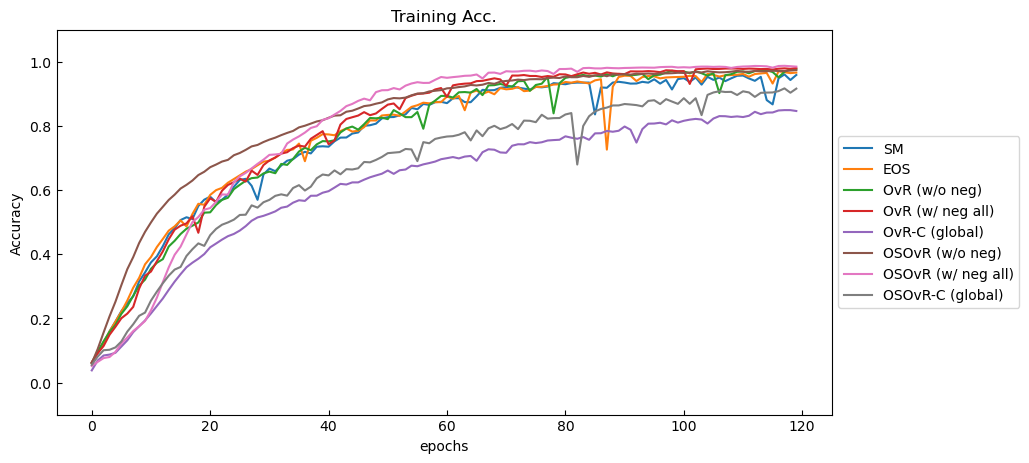

In [ ]:
PROTOCOL = 2

log_item = log_item_list[ITEM_IDX][0]
y_axis_name = log_item_list[ITEM_IDX][1]
plot_title = log_item_list[ITEM_IDX][2]

data_info = sm_data_info_1[PROTOCOL-1] + eos_data_info_1[PROTOCOL-1]
data_info += ovr_data_info_2[PROTOCOL-1] + ovr_data_info_3_C[PROTOCOL-1][-1:]
data_info += dsovr_data_info_2[PROTOCOL-1] + dsovr_data_info_3_C[PROTOCOL-1][-1:]

plt.figure(figsize=(10,5))
for idx, d_i in enumerate(data_info):

    logs = evals.get_training_log(d_i, log_item)

    plt.plot(logs, label=d_i['label'], linestyle='-', color=CMAP[idx])
    plt.ylim((-0.1,1.1))
    plt.ylabel(y_axis_name)
    plt.xlabel('epochs')
    plt.title(plot_title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tick_params(direction='in')


#### Protocol 3

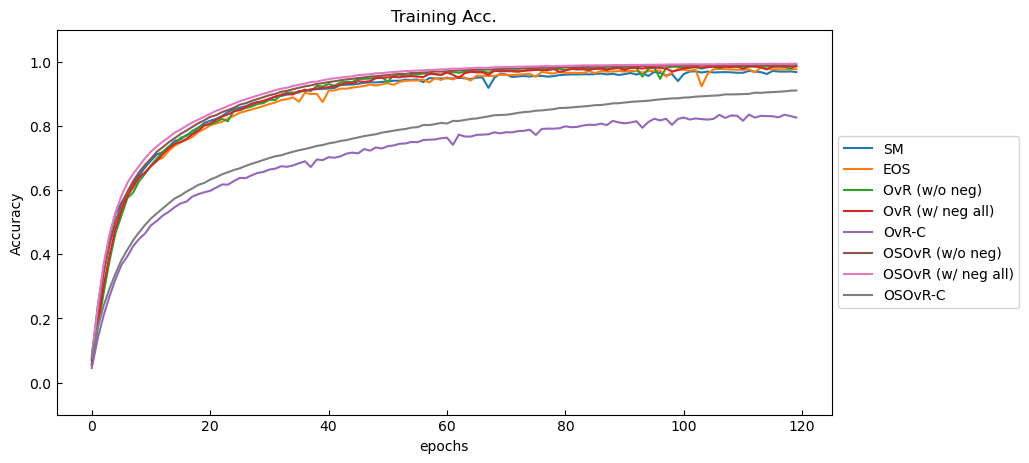

In [ ]:
PROTOCOL = 3

log_item = log_item_list[ITEM_IDX][0]
y_axis_name = log_item_list[ITEM_IDX][1]
plot_title = log_item_list[ITEM_IDX][2]

data_info = sm_data_info_1[PROTOCOL-1] + eos_data_info_1[PROTOCOL-1]
data_info += ovr_data_info_2[PROTOCOL-1] + ovr_data_info_3_C[PROTOCOL-1]
data_info += dsovr_data_info_2[PROTOCOL-1] + dsovr_data_info_3_C[PROTOCOL-1]

plt.figure(figsize=(10,5))
for idx, d_i in enumerate(data_info):

    logs = evals.get_training_log(d_i, log_item)

    plt.plot(logs, label=d_i['label'], linestyle='-', color=CMAP[idx])
    plt.ylim((-0.1,1.1))
    plt.ylabel(y_axis_name)
    plt.xlabel('epochs')
    plt.title(plot_title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tick_params(direction='in')
